In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
workspace = '/content/gdrive/MyDrive/ColabNotebooks/proj_name'
os.chdir(workspace)
os.listdir()

Mounted at /content/gdrive


['data', 'CNN-VAE.ipynb']

# PROJ NAME

In [1]:
# generic usage
import os
# import sys
import numpy as np
# import math
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import random
# import pickle
from datetime import datetime

# basic torch packages
import torch
from torch import optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# import torchvision
# from PIL import Image
from collections import OrderedDict
import importlib
from myutils import *  # import my tools


## 网络超参数

In [31]:
hyper_params = {
    "device": "cpu",
    # "device": "cuda",
    "batch_size": 64,
    "lr_rate": 0.001,
    "grad_clip_val": 0.01,
    "epochs": 100,
    "enc_MLP": (1024, 512, 256, 128, 64, 32),
    "z2p_MLP": (32, 16, 8, 4, 3),
}

hyper_params["latent_len"] = hyper_params["enc_MLP"][-1]
hyper_params["dec_MLP"] = tuple(hyper_params["enc_MLP"][::-1])
hyper_params["p2z_MLP"] = tuple(hyper_params["z2p_MLP"][::-1])

[print(i[0], "->", i[1]) for i in hyper_params.items()];

device -> cpu
batch_size -> 64
lr_rate -> 0.001
grad_clip_val -> 0.01
epochs -> 100
enc_MLP -> (1024, 512, 256, 128, 64, 32)
z2p_MLP -> (32, 16, 8, 4, 3)
latent_len -> 32
dec_MLP -> (32, 64, 128, 256, 512, 1024)
p2z_MLP -> (3, 4, 8, 16, 32)


## 导入数据

设置本数据的dataset类

In [32]:
from data.PID_data import PID_data
dataset = PID_data("../data/data_Kpid-cases_Kpid-rets_3.pkl", params_lim=True)
dataset.to(to_type = torch.float32, to_device = hyper_params["device"])

dataloader = DataLoader(
    dataset = dataset,
    batch_size = hyper_params["batch_size"],
    shuffle = True,
    # num_workers = 2,
    pin_memory = True,
)

print("Batch number:", len(dataloader))

data params shape: (9975, 3)
data ctrls shape: (9975, 1024)
data type changed to: torch.float32
data device changed to: cpu
Batch number: 156


## Net Definition

In [33]:
try:
    importlib.reload(NET)
except NameError as err:
    import NET
    print("first import NET.py, not reload")
    pass


In [38]:
model = NET.MODEL(hyper_params).to(hyper_params['device'])
print("Training on {} device".format(model.hpm['device']))
# print(model)

Training on cpu device


## run

In [39]:
optimizer = optim.Adam(model.parameters(), lr=model.hpm["lr_rate"])  # hy_pms['lr']


In [40]:
wl = WatchLoss(mov_avg_len=10, ratio_max=10)  # the watch dog


!! Training finished


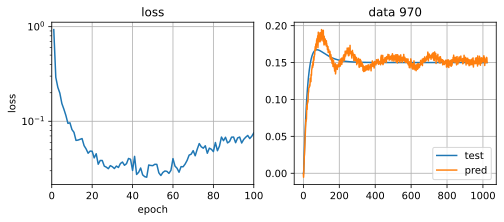

In [41]:
# epoch_num = model.hpm["epochs"]
epoch_num = 100
# batch_print_num = len(dataloader) // 3
amt = Animator(1,2)
amt.config_ax_(amt.axes[0], title="loss", xlabel='epoch', ylabel='loss', xlim=(0,epoch_num), yscale='log')
amt.config_ax_(amt.axes[1], title="data 970", legend=['test', 'pred'])

model.train()
for epoch_idx in range(epoch_num):
    wl.add_epoch_loss()
    for batch_idx, [_, train_ctrls] in enumerate(dataloader):
        optimizer.zero_grad()
        train_ctrls = train_ctrls.to(model.hpm["device"])
        pred_ctrls, mu, logvar = model.forward(train_ctrls)
        loss = model.loss_func(pred_ctrls, train_ctrls, mu, logvar, beta=1)
        if wl.check_batch_loss(loss.detach().cpu().numpy() / train_ctrls.size(0)):
            break
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), model.hpm["grad_clip_val"])
        optimizer.step()
        wl.cum_epoch_loss(loss.item())
        # if (batch_idx+1) % batch_print_num == 0:
        #     print("Run\tEpoch: [{}/{}]  Item: [{}/{}]  AvgLoss: {:.4e}".format(
        #         epoch_idx+1, epoch_num,
        #         (batch_idx + 1) * model.hpm["batch_size"], len(dataloader.dataset),
        #         wl.show_batch_loss_avg()))
    if wl.toStop:
        optimizer.zero_grad()
        print("Tip\tEarly Stop at Epoch: [{}/{}]  LossRatio: {:.1f}".format(
            epoch_idx+1, epoch_num, wl.ratio_this))
        break
    print("Run\tEpoch [{}/{}]  AvgLoss: {:.4e}".format(
        epoch_idx+1,
        epoch_num,
        wl.avg_epoch_loss(len(dataloader.dataset))))
    model.eval()
    amt.plot_ax(amt.axes[0], np.arange(len(wl.epoch_loss_arr))+1, wl.epoch_loss_arr)
    test_ctrl = dataset[970][1]
    pred_ctrl, _, _ = model(test_ctrl.to(model.hpm['device']))
    pred_ctrl = pred_ctrl.detach().cpu().numpy()
    amt.plot_ax(amt.axes[1], np.arange(len(pred_ctrl)), np.vstack((test_ctrl, pred_ctrl)))
    amt.show()

print("!! Training finished")
model.eval();  # 固定参数, 仅对模型进行评估


## 评估

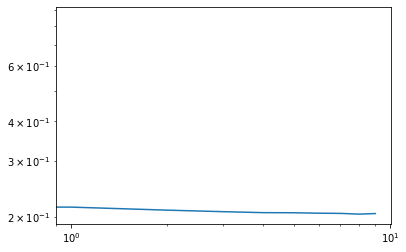

In [9]:
plt.plot(wl.epoch_loss_arr)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [10]:
def showFit(input = None):
    """
    显示一些拟合结果,
    :param input = None, int, list:
    """
    if input == None:
        idx_list = random.sample(range(len(dataset)), 4)
    elif type(input) == int:
        idx_list = random.sample(range(len(dataset)), input)
    elif type(input) == list:
        idx_list = input
    idx_cnt = len(idx_list)
    # test_params = dataset.params[idx_list]
    test_ctrls = dataset.ctrls[idx_list]  # 保持在cpu上
    pred_ctrls = model(test_ctrls.to(model.hpm["device"]))[0].data
    pred_ctrls = pred_ctrls.view(test_ctrls.size(0),-1).to("cpu")
    test_ctrls = test_ctrls.view(test_ctrls.size(0),-1).to("cpu")

    fig = plt.figure(figsize=(4*idx_cnt, 3*1), dpi=200)

    data_fig = list(zip(idx_list, test_ctrls, pred_ctrls))
    for i, (idx, t, p) in enumerate(data_fig):
        ax = fig.add_subplot(1, idx_cnt, i + 1)
        ax.plot(t.numpy(), label='test')
        ax.plot(p.numpy(), label='pred')
        ax.set_title('Kpid param ' + str(idx) +'\n' + str(dataset.params[idx].numpy()))
        ax.legend()
        ax.grid()
    plt.show()

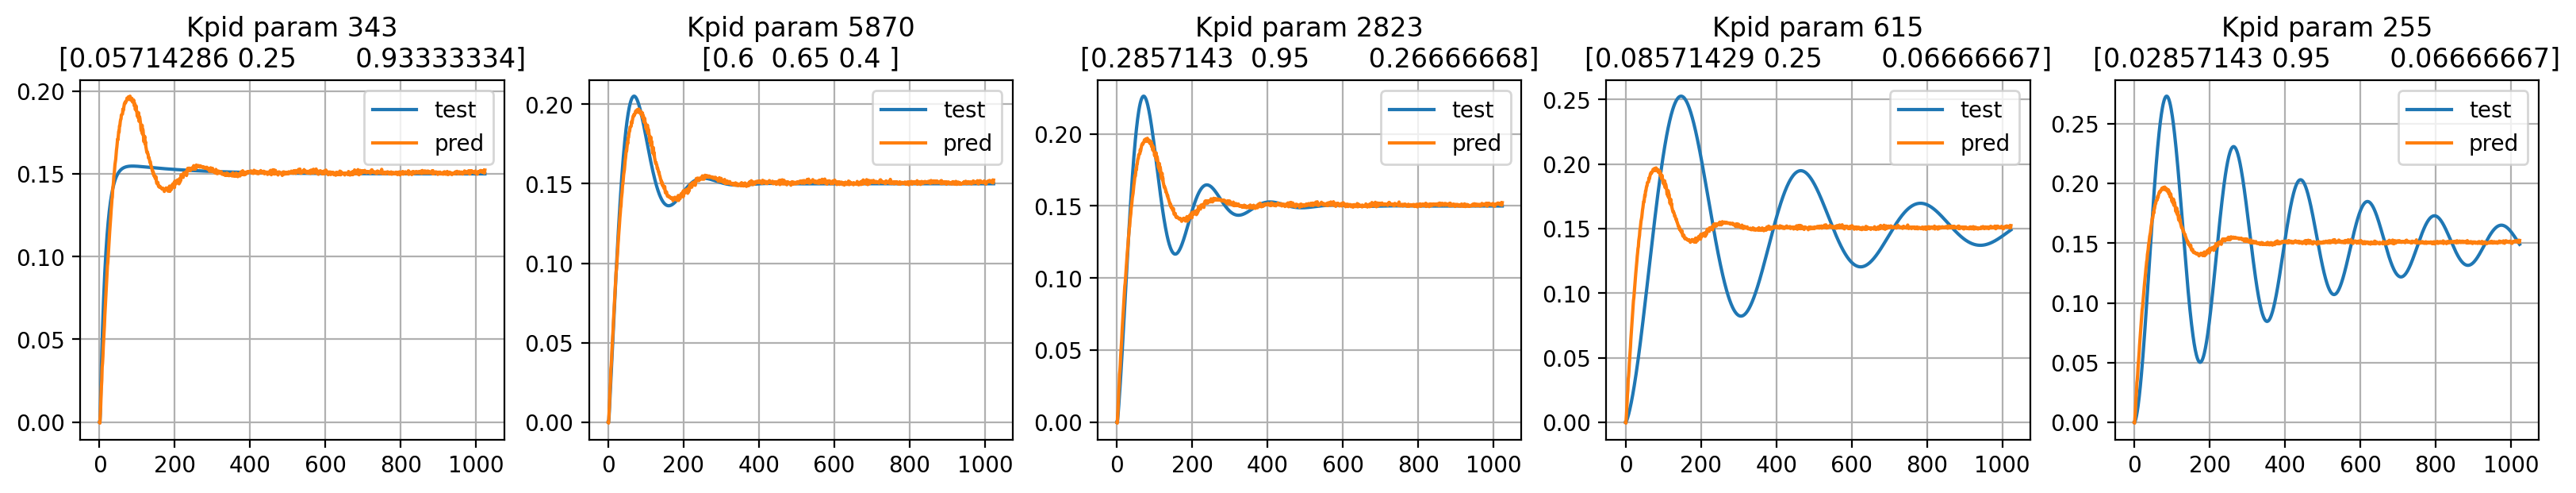

In [11]:
showFit([343, 5870, 2823, 615, 255])


In [ ]:
def showFit_1(input = None):
    """
    显示一些拟合结果,
    :param input = None, int, list:
    """
    global dataset
    if input == None:
        idx_list = random.sample(range(len(dataset)), 4)
    elif type(input) == int:
        idx_list = random.sample(range(len(dataset)), input)
    elif type(input) == list:
        idx_list = input
    idx_cnt = len(idx_list)
    # test_params = dataset.params[idx_list]
    test_params, test_ctrls = dataset[idx_list]  # 保持在cpu上
    pred_params = model.forward_1(test_ctrls.to(model.hpm["device"]))[0].data
    pred_params = pred_params.view(test_ctrls.size(0),-1).to("cpu")
    pred_params = pred_params.view(test_ctrls.size(0),-1).to("cpu")

    fig = plt.figure(figsize=(4*idx_cnt, 3*1), dpi=200)

    data_fig = list(zip(idx_list, test_params, pred_params))
    for i, (idx, t, p) in enumerate(data_fig):
        ax = fig.add_subplot(1, idx_cnt, i + 1)
        ax.plot(t.numpy(), label='test')
        ax.plot(p.numpy(), label='pred')
        ax.set_title('Kpid param ' + str(idx) +'\n' + str(dataset.params[idx].numpy()))
        ax.legend()
        ax.grid()
    plt.show()

## 保存

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
timestamp

In [ ]:
save_names = {
    'model': './data/CNN-VAE-model-'+timestamp+'.pth',
    'state_dict': './data/CNN-VAE-state_dict-'+timestamp+'.pth',
    'loss': './data/CNN-VAE-loss-'+timestamp+'.pth',
}

os.chdir(workspace)

torch.save(model.state_dict(), save_names['state_dict'])
# model.load_state_dict(torch.load('./data/CNN-VAE-state_dict.pth'))
torch.save(model, save_names['model'])
# model =torch.load('./data/CNN-VAE-model.pth')
torch.save(wl.epoch_loss_arr, save_names['loss'])
